In [12]:
import pandas as pd
import matplotlib.pyplot as plt


Text(0.5, 1.0, '/home/guy/code/2d-robot-prognostics/shoulder10-elbow10.csv')

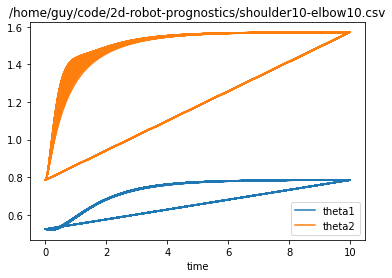

In [13]:
with open('header.txt') as f:
    header = f.readline().split('\t')

fname='/home/guy/code/2d-robot-prognostics/shoulder10-elbow10.csv'
df = pd.read_csv(fname, sep=' ', names=header)
df.plot(x='time', y=['theta1','theta2'])
plt.title(fname)

Text(0.5, 1.0, '/home/guy/code/2d-robot-prognostics/shoulder10-elbow10.csv')

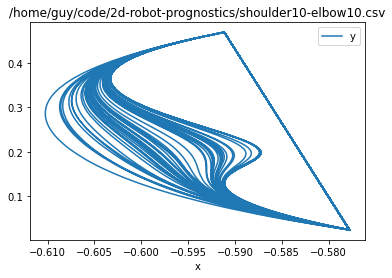

In [15]:
df.plot(x='x', y='y')
plt.title(fname)
